# FunOS module initialization analysis

This notebook analyze module initilzation, durations and dependencies.
Input file is `modules.json`.

**References** for the notebook:
- [Using simple barh based implementation](https://towardsdatascience.com/gantt-charts-with-pythons-matplotlib-395b7af72d72)
- [Barh based with hints on how to make better representation](https://medium.com/geekculture/generate-gantt-chart-in-python-9d1e1fe9103e)

NEXT:
- have it a way to generate web page
- generate output from f1
- may require manual packing
- check plotly one more time (just use line chart ?) or use gannt style, which requre datetime conversion

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import Tuple

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

In [2]:
def convert_to_list_of_dicts(raw_data: dict, convert_time_to_ns: bool, debug: bool) -> list:
    """convert the raw data (dict based format) to list of dicts

    Parameters
    ----------
    raw_data : dict
        raw data in dict format, module_name: [start_time, end_time]
    
    convert_time_to_ns : bool, optional
        convert time to ns, by default True
    
    Returns
    -------
    fun_module_init_list : list
        list of dicts, each dict is a module, with keys: module_name, start_time, finish_time
    """
    time_unit = 0
    if convert_time_to_ns:
        time_unit = 1000000000
    fun_module_init_list = []
    for module_name, module_data in raw_data.items():
        temp_dict = {}
        temp_dict['module_name'] = module_name
        temp_dict['start_time'] = time_unit * float(module_data[0])
        temp_dict['finish_time'] = time_unit * float(module_data[1])
        # add duration column
        temp_dict['module_init_duration'] = temp_dict['finish_time'] - temp_dict['start_time']
        fun_module_init_list.append(temp_dict)

    if debug:
        print("List created")
        print(fun_module_init_list[:2])
        print("Time conversion unit: {}".format(time_unit))
        # convert list of dicts to pandas dataframe
        # fun_module_init_df = pd.DataFrame(fun_module_init_list)
        # fun_module_init_df.head()
    
    return fun_module_init_list

In [3]:
def load_input_data(input_file: str, convert_time_to_ns: bool = True, debug: bool=False) -> pd.DataFrame:
    """load input data from json file and convert to pandas dataframe

    Parameters
    ----------
    input_file : str
        input file name
    
    Returns
    -------

    fun_module_init_df : pd.DataFrame
        pandas dataframe with module_name, start_time, finish_time, module_init_duration

    """
    with open(input_file, 'r') as f:
        fun_module_init = json.load(f)
    
    if debug:
        print("Number of modules: {}".format(len(fun_module_init)))
        print("fun_module_init.keys: {}".format(fun_module_init.keys()))
        print("fun_module_init['accel_telem-init']: {}".format(fun_module_init['accel_telem-init']))

    # convert to list of dicts
    fun_module_init_list = convert_to_list_of_dicts(fun_module_init, convert_time_to_ns=convert_time_to_ns, debug=debug)

    # convert to df
    fun_module_init_df = pd.DataFrame(fun_module_init_list)
    fun_module_init_df.set_index('module_name', inplace=True)

    return fun_module_init_df


## Load raw json file and convert it to dataframe

Example input:
```
{
    "accel_telem-init": [0.024845458, 0.024987833],
    "adi-init": [0.040308791, 0.040344291],
    "app-init": [0.029524875, 0.029535041],
...
```

Example output:
```
	module_name	start_time	finish_time
0	accel_telem-init	0.024845	0.024988
1	adi-init	0.040309	0.040344
2	app-init	0.029525	0.029535
3	bin_ctl_handler-init	0.002356	0.002492
4	bm-init	0.030727	0.030735
```

In [4]:
# load config, TODO use config file

INPUT_FILE = "modules.json"

In [5]:
# MAIN CALLS
# load input data

fun_module_init_df = load_input_data(INPUT_FILE, convert_time_to_ns=True, debug=False)
fun_module_init_df.head()

,start_time,finish_time,module_init_duration
module_name,,,
accel_telem-init,24845458.0,24987833.0,142375.0
adi-init,40308791.0,40344291.0,35500.0
app-init,29524875.0,29535041.0,10166.0
bin_ctl_handler-init,2355583.0,2492166.0,136583.0
bm-init,30726791.0,30735416.0,8625.0


In [6]:
print("module init summary: time in ns")
fun_module_init_df.describe().round()

module init summary: time in ns


,start_time,finish_time,module_init_duration
count,83.0,83.0,83.0
mean,34911058.0,37167342.0,2256284.0
std,47729428.0,50534131.0,11696933.0
min,50208.0,58708.0,4584.0
25%,6286042.0,6293646.0,14438.0
50%,26320541.0,26407333.0,70375.0
75%,30746270.0,30776396.0,177624.0
max,200082875.0,200089500.0,89382792.0


In [7]:
print("Total number of modules: {}".format(len(fun_module_init_df)))

Total number of modules: 83


## Plot events

In [8]:
# import plotly.express as px

In [9]:
def get_start_finish_times(df: pd.DataFrame, debug: bool = False) -> pd.DataFrame:
    """Utility to get start and finish times from df"""

    start_min = df['start_time'].min() # first module start time
    finish_max = df['finish_time'].max() # last module finish time
    duration = finish_max - start_min # time between the first module start time and last module finish time

    if debug:
        print("start_min (start time of the first module): {}".format(start_min))
        print("finish_max: (finish time of the last module) {}".format(finish_max))
        # print("duration: (finish_max - start_min) {}".format(finish_max - start_min))
        # summary
        total_module_time = df['module_init_duration'].sum()
        print("Total module init time: {} ns".format(total_module_time))
        print("duration (time between the first module start time and last module finish time): {} ns".format(finish_max - start_min))
        print("'Total module init time' / 'duration' (greater than 1 is better, which means more concurrent modules init): {} ".format(((total_module_time / duration)).round(4)))
    
    return start_min, finish_max, duration

In [10]:
def plot_module_time_chart(df: pd.DataFrame, small_set: int=-1, use_plt: bool=True, sort_by: str="start_time", title: str='FunOS Module Init Duration', group_table: dict=None, cutoff_group_names: int=30, save_file_name: str ="fun_module_init_chart.png", debug: bool=False) -> None:
    """Plot the module init time chart
    Parameters
    ----------
    df : pd.DataFrame
        dataframe with module init data
    small_set : int, optional
        number of rows to plot, by default -1 (plot all)
    sort_by : str, optional
        sort by column, by default "start_time"
    title : str, optional
        title of the chart, by default 'FunOS Module Init Duration'
    group_table : dict, optional
        group table, by default None, if not None, group the modules based on the group_table
    cutoff_group_names : int, optional
        cutoff group names, by default 12, cut off text display for group names
    
    Returns
    -------
    None
    """
    # add max min for creating tick

    df_use = df.copy()

    X_disp_granualarity = 10
    X_granualarity = 1000000
    x_tick_str = "ms"
    # if X_granualarity == 1000000:
    #     x_tick_str = "ms"
    # elif X_granualarity == 1000000000:
    #     x_tick_str = "s"

    df_use.sort_values(by=[sort_by], inplace=True, ascending=True)

    if small_set > 0:
        df_use = df_use[:small_set]
    
    start_min, finish_max, duration = get_start_finish_times(df_use, debug=debug)

    x_ticks = np.arange(0, duration, X_disp_granualarity * X_granualarity)
    x_tick_labels = ["{} {}".format(str(int(x)), x_tick_str) for x in x_ticks/X_granualarity]
    
    if debug:
        print("x_ticks: {}".format(x_ticks[:10]))
        print("x_tick_labels: {}".format(x_tick_labels[:10]))


    figsize=(40, len(df_use))
    print("figsize: {}".format(figsize))
    if debug:
        display(df_use.head())
        display(df_use.describe())

    if use_plt:
        # fig, ax = plt.subplots(1, figsize=(40, 50))
        fig, ax = plt.subplots(1, figsize=figsize)
        p1 = ax.barh(df_use.index, width=df_use['module_init_duration'], left=df_use['start_time'])

        ax.set(xlabel='ms', ylabel='Modules')

        #Invert y axis
        plt.gca().invert_yaxis()

        #customize x-ticks
        plt.xticks(ticks=x_ticks, labels=x_tick_labels)

        # title
        plt.title(title, fontsize=20)

        #rotate x-ticks
        plt.xticks(rotation=60)
        #add grid lines
        plt.grid(axis='x', alpha=0.5)
        plt.grid(axis='y', alpha=0.5)
        # test

        if group_table:
            x_base = 6000000
            for i, (k, v) in enumerate(group_table.items()):
                if len(v) > cutoff_group_names:
                    v_str = "{}...(total: {})".format(v[:10], len(v))
                else:
                    v_str = "{}".format(v[:10])
                ax.text(x_base*(i+1), i, v_str, fontsize=20, color='red')
                # ax.text(20000000, 1, 'Unicode: Institut für Festkörperphysik')

        #save fig
        plt.savefig(save_file_name)
        plt.show()
    else:
        # use plotly
        # plotly doesn't support 'left' argument, so need to create manualy bars
        # https://community.plotly.com/t/broken-barh-plot/36496
        assert False, "Ploty not supported yet"
        # fig = px.timeline(df, x_start="start_time", x_end="finish_time", y=df_use.index, title=title)
        # fig.update_yaxes(autorange="reversed") # otherwise tasks are listed from the bottom up
        # fig.show()

    del df_use

start_min (start time of the first module): 50208.0
finish_max: (finish time of the last module) 200089500.0
Total module init time: 187271539.0 ns
duration (time between the first module start time and last module finish time): 200039292.0 ns
'Total module init time' / 'duration' (greater than 1 is better, which means more concurrent modules init): 0.9362 
x_ticks: [       0. 10000000. 20000000. 30000000. 40000000. 50000000. 60000000.
 70000000. 80000000. 90000000.]
x_tick_labels: ['0 ms', '10 ms', '20 ms', '30 ms', '40 ms', '50 ms', '60 ms', '70 ms', '80 ms', '90 ms']
figsize: (40, 83)


,start_time,finish_time,module_init_duration
module_name,,,
modcfg-init,50208.0,58708.0,8500.0
dma_utils-init,160041.0,268541.0,108500.0
hw_dmae_sim-init,223041.0,239666.0,16625.0
hw_emmc-init,515458.0,569875.0,54417.0
hw_hu_cfg-init,565083.0,2349041.0,1783958.0


,start_time,finish_time,module_init_duration
count,8.300000e+01,8.300000e+01,8.300000e+01
mean,3.491106e+07,3.716734e+07,2.256284e+06
std,4.772943e+07,5.053413e+07,1.169693e+07
min,5.020800e+04,5.870800e+04,4.584000e+03
25%,6.286042e+06,6.293646e+06,1.443750e+04
50%,2.632054e+07,2.640733e+07,7.037500e+04
75%,3.074627e+07,3.077640e+07,1.776245e+05
max,2.000829e+08,2.000895e+08,8.938279e+07


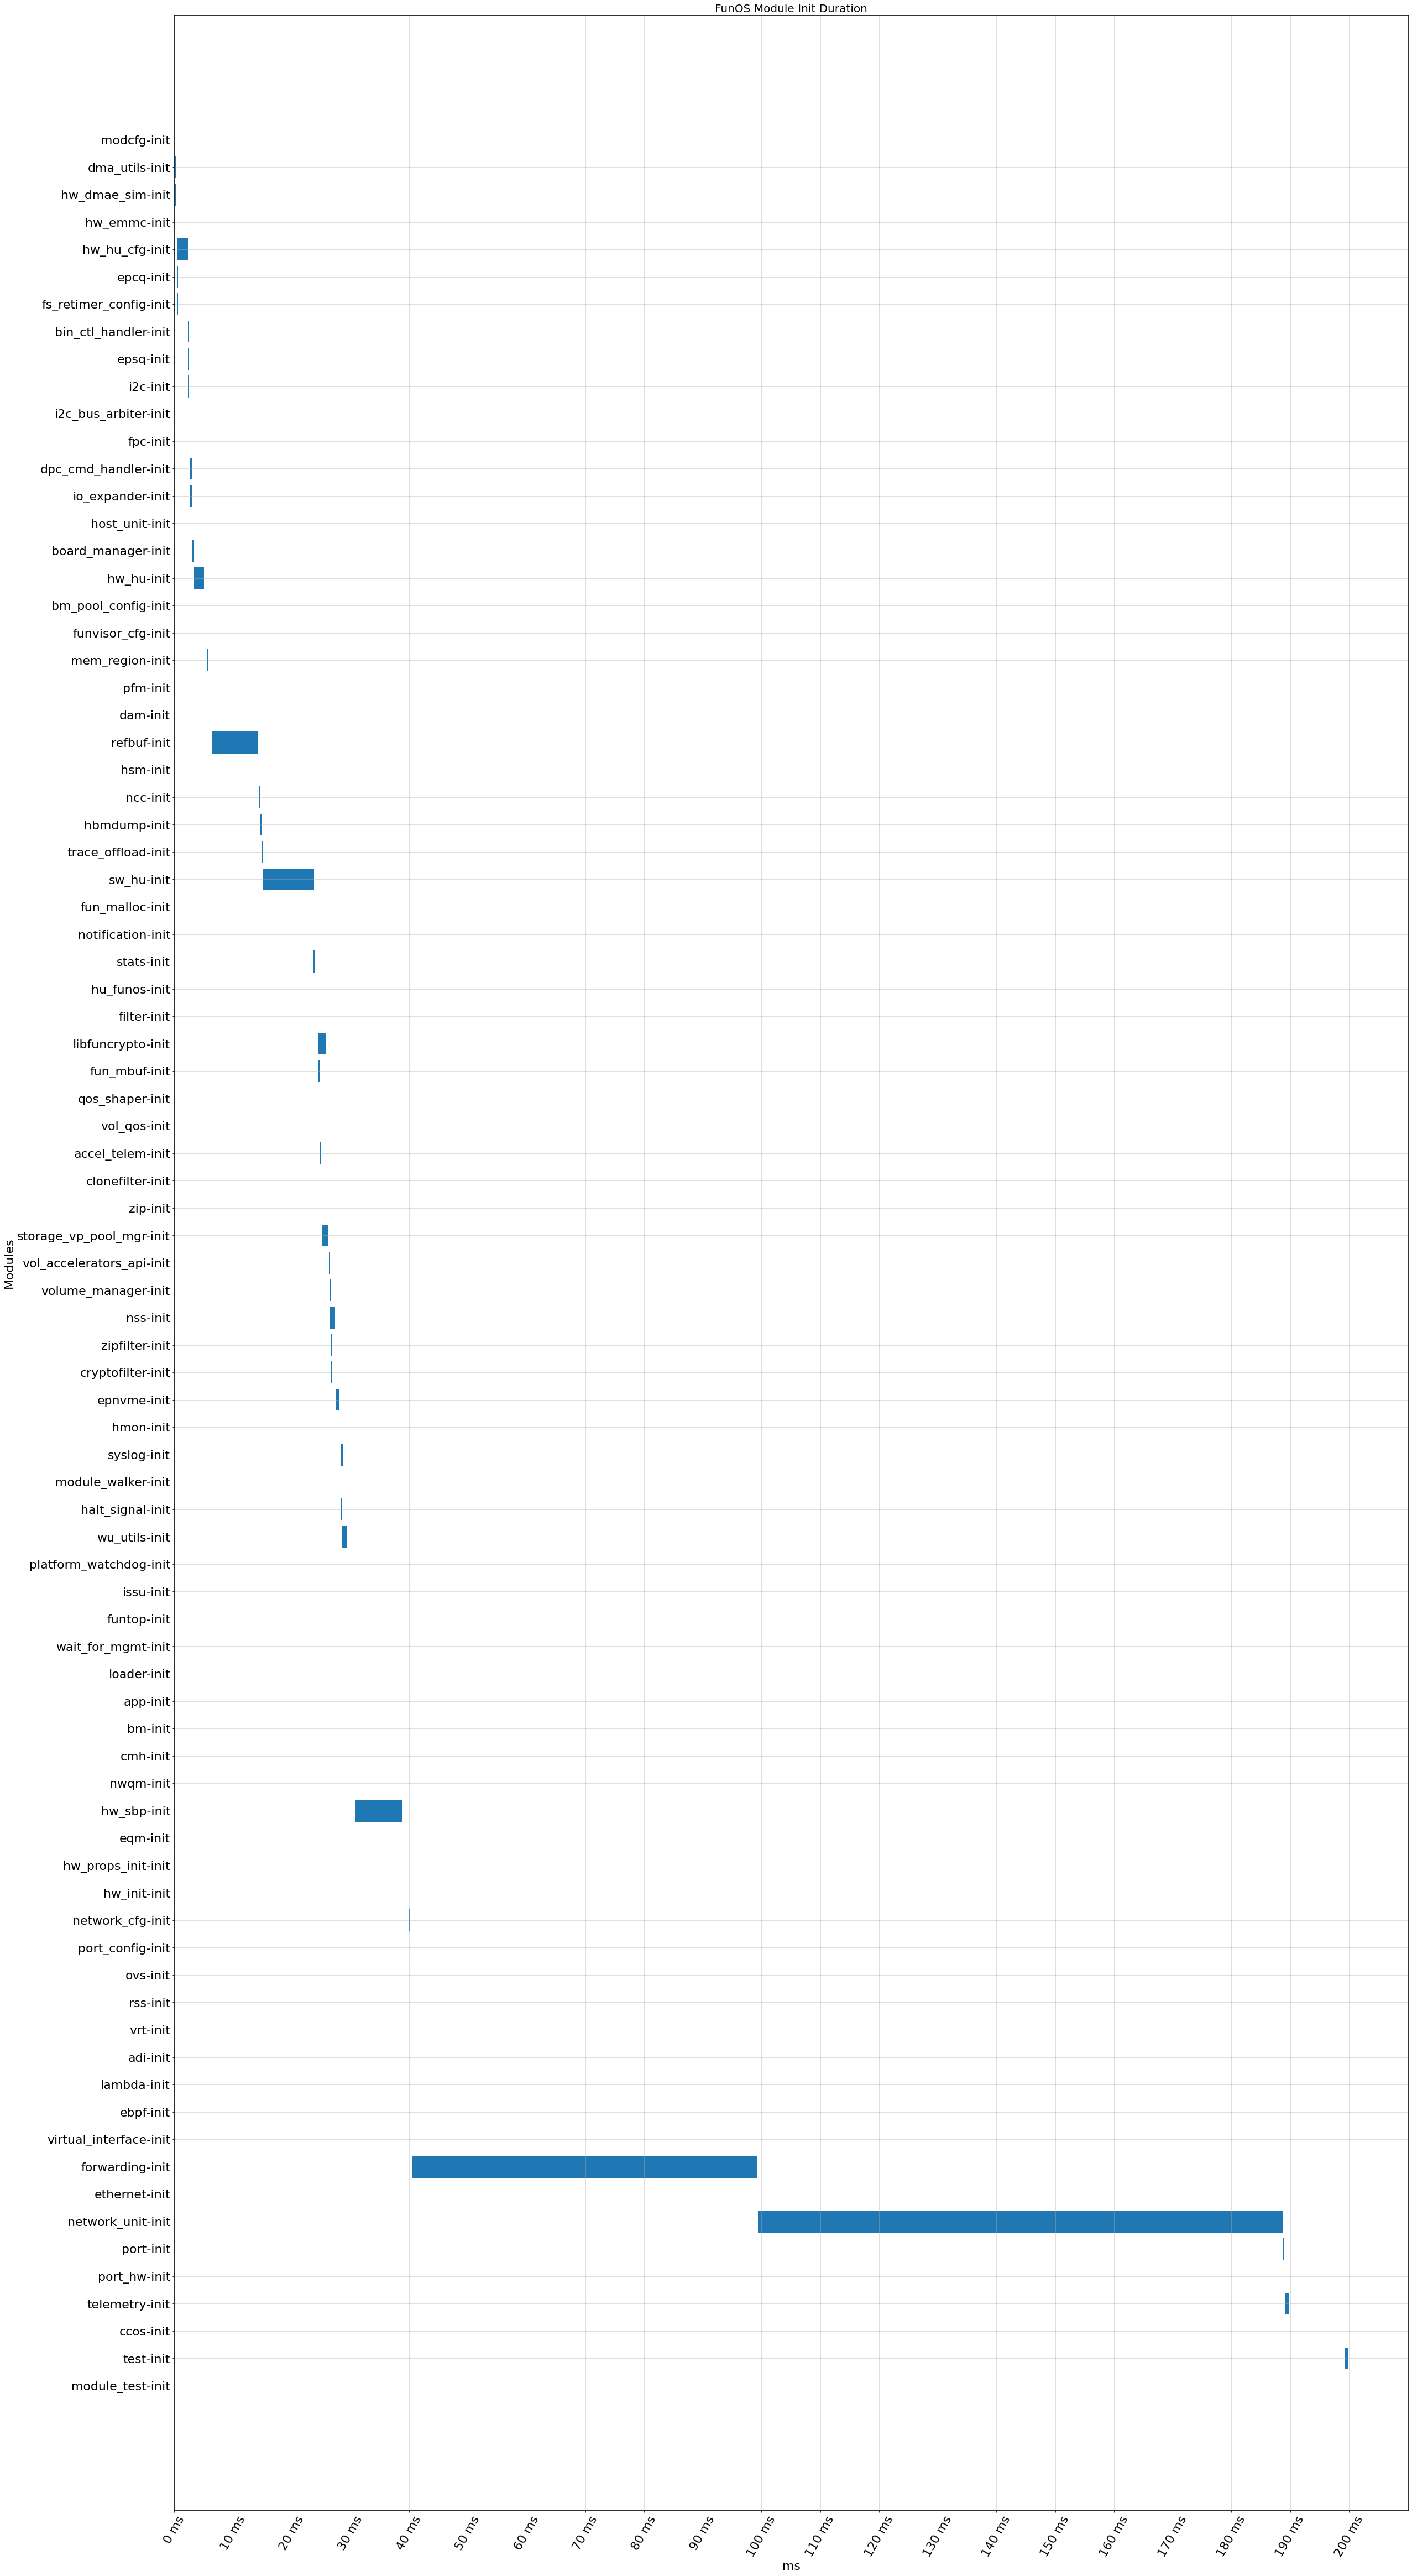

In [11]:
# MAIN CALLS
# plot the events
plot_module_time_chart(fun_module_init_df, debug=True)

In [12]:
fun_module_init_df.loc[['forwarding-init', 'network_unit-init', 'ethernet-init']]
# fun_module_init_df.index
# fun_module_init_df.columns

,start_time,finish_time,module_init_duration
module_name,,,
forwarding-init,40587541.0,99232375.0,58644834.0
network_unit-init,99351791.0,188734583.0,89382792.0
ethernet-init,99276375.0,99303375.0,27000.0


## Collapsing short activities

In [13]:
def get_duration_threshold(df: pd.DataFrame, threshold: float=0.10) -> float:
    """Get the threshold value from the dataframe
    Parameters
    ----------
    df : pd.DataFrame
        dataframe with module init data
    threshold : float, optional
        threshold value, by default 0.10
    Returns
    -------
    float
        threshold value
    """
    max_duration = df['module_init_duration'].max()

    return float(int(max_duration * threshold))


In [14]:
def get_collapsed_df(df_in:pd.DataFrame, threshold: float, debug: bool = False) -> Tuple[pd.DataFrame, dict]:
    """Collpased df using the threshold

    Parameters
    ----------
    df : pd.DataFrame
        dataframe with module init data
    threshold : float
        threshold value

    Returns
    -------
    pd.DataFrame
        collapsed dataframe
    dict
        group table, key is the group name, value is the list of modules in the group
    """

    df = df_in.copy()
    df.sort_values(by=['start_time'], inplace=True, ascending=True)

    # df_collapsed['module_init_duration'] = df_collapsed['module_init_duration'].apply(lambda x: x if x > threshold else 0)
    # df_collapsed = df_collapsed[df_collapsed['module_init_duration'] > 0]
    new_events = []
    n_event = 0
    num_included = 0
    cur_duration = 0 # current start to the finish of the last event
    cur_start = 0
    cur_finish = 0
    last = len(df)
    group_table = {}
    for i in range(len(df)):
        name, start, finish, duration = df.index[i], df.iloc[i].start_time, df.iloc[i].finish_time, df.iloc[i].module_init_duration
        if debug:
            print(name, start, finish, duration)

        if cur_duration == 0:
            num_included = 0
            cur_duration = duration
            cur_start = start
            cur_finish = finish
            group_modules = []
        
        cur_finish = max(cur_finish, finish)
        cur_duration = cur_finish - cur_start
        # print("cur_start, cur_finish, cur_duration: {}, {}".format(cur_start, cur_finish, cur_duration))

        # peek the next check if next module passes the thresholds
        next_module_pass_threshold = False
        if i < last - 1:
            next_name, next_start, next_finish, next_duration = df.index[i+1], df.iloc[i+1].start_time, df.iloc[i+1].finish_time, df.iloc[i+1].module_init_duration
            next_finish = max(cur_finish, next_finish)
            # print("next_finish {}, next_finish - cur_start {}".format(next_finish, next_finish - cur_start))
            # if next duration is more than threshold and there is more than one collapsed, then stop collapsing the current modules
            if next_finish - cur_start > threshold and num_included > 0:
                next_module_pass_threshold = True
                group_modules.append(name)

        
        # if cur_duration + duration > threshold:
        if cur_duration > threshold or next_module_pass_threshold:
            # peek the next one and keep adding until the threshold is reached
            # create a new onew
            group_name = "group_{}".format(n_event)
            new_d = {"module_name" : group_name, "start_time" : cur_start, "finish_time" : cur_finish, "module_init_duration" : cur_duration}
            if debug:
                print("includes {}, added: {}".format(num_included, new_d))
            new_events.append(new_d)
            cur_duration = 0
            n_event += 1
            group_table[group_name] = group_modules if num_included > 0 else [name]
            # group_modules = []
        else:
            group_modules.append(name)
            num_included += 1
                
    if cur_duration != 0:
        group_name = "group_{}".format(n_event)
        new_d = {"module_name" : group_name, "start_time" : cur_start, "finish_time" : cur_finish, "module_init_duration" : cur_duration}
        if debug:
            print("added: {}".format(new_d))
        new_events.append(new_d)
        group_table[group_name] = group_modules

    df_collapsed = pd.DataFrame(new_events)
    df_collapsed.set_index('module_name', inplace=True)
    df_collapsed.head()
    return df_collapsed, group_table

In [15]:
def print_group_table(group_table: dict):
    """Print the group table

    Parameters
    ----------
    group_table : dict
        group table, key is the group name, value is the list of modules in the group
    """
    for key, value in group_table.items():
        print("{}({}): {}".format(key, len(value), value))
    
    # for k, v in group_table.items():
    #     print("{}:".format(k))
    #     for m in v:
    #         print("  {}".format(m))

threshold: 8938279.0
figsize: (40, 10)


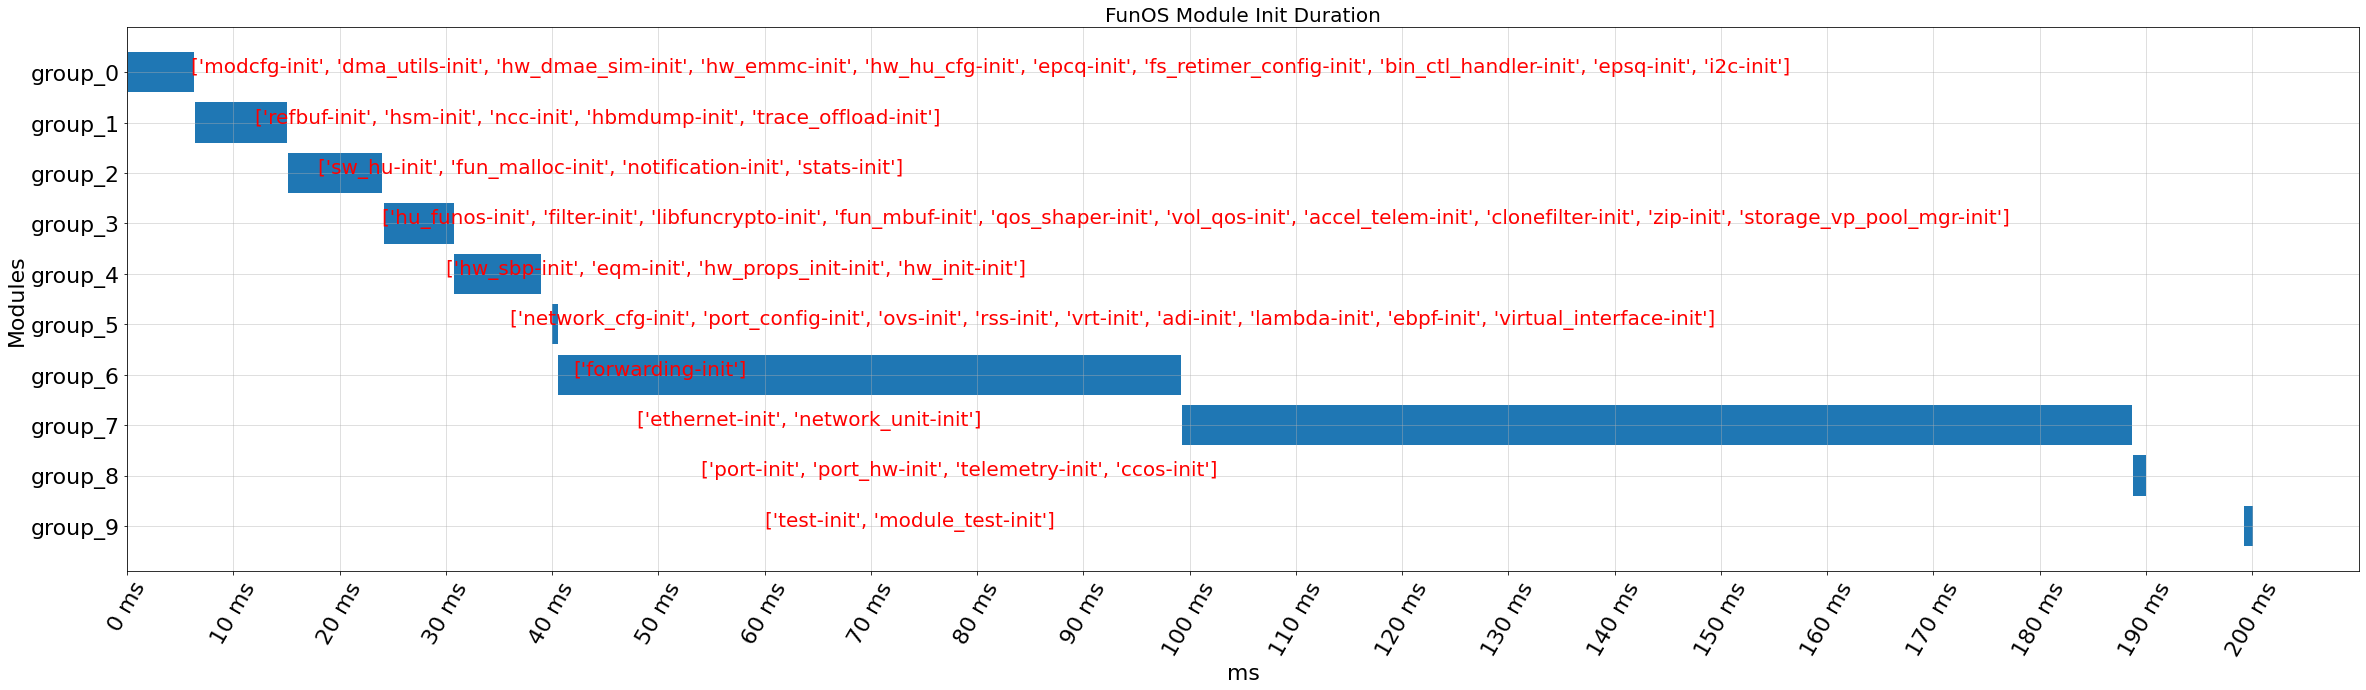

group_0(22): ['modcfg-init', 'dma_utils-init', 'hw_dmae_sim-init', 'hw_emmc-init', 'hw_hu_cfg-init', 'epcq-init', 'fs_retimer_config-init', 'bin_ctl_handler-init', 'epsq-init', 'i2c-init', 'i2c_bus_arbiter-init', 'fpc-init', 'dpc_cmd_handler-init', 'io_expander-init', 'host_unit-init', 'board_manager-init', 'hw_hu-init', 'bm_pool_config-init', 'funvisor_cfg-init', 'mem_region-init', 'pfm-init', 'dam-init']
group_1(5): ['refbuf-init', 'hsm-init', 'ncc-init', 'hbmdump-init', 'trace_offload-init']
group_2(4): ['sw_hu-init', 'fun_malloc-init', 'notification-init', 'stats-init']
group_3(30): ['hu_funos-init', 'filter-init', 'libfuncrypto-init', 'fun_mbuf-init', 'qos_shaper-init', 'vol_qos-init', 'accel_telem-init', 'clonefilter-init', 'zip-init', 'storage_vp_pool_mgr-init', 'vol_accelerators_api-init', 'volume_manager-init', 'nss-init', 'zipfilter-init', 'cryptofilter-init', 'epnvme-init', 'hmon-init', 'syslog-init', 'module_walker-init', 'halt_signal-init', 'wu_utils-init', 'platform_watch

In [16]:
# MAIN CALLS
threshold = get_duration_threshold(fun_module_init_df, threshold=0.10)
print("threshold: {}".format(threshold))

fun_module_init_df_collapsed, group_table = get_collapsed_df(fun_module_init_df, threshold, debug=False)

plot_module_time_chart(fun_module_init_df_collapsed, debug=False, group_table=group_table, save_file_name="module_init_time_collapsed.png")

print_group_table(group_table)

In [17]:
stop

NameError: name 'stop' is not defined

In [ ]:
small_df = fun_module_init_df.copy()

In [ ]:
small_df.sort_values(by=['start_time'], inplace=True, ascending=True)

In [ ]:
small_df.head()

In [ ]:
# t = small_df[:42]
t = small_df
display(t)

In [ ]:
plot_module_time_chart(t, debug=False)

In [ ]:
threshold

In [ ]:
new_events = []
n_event = 0
num_included = 0
cur_duration = 0 # current start to the finish of the last event
cur_start = 0
cur_finish = 0
last = len(t)
group_table = {}
for i in range(len(t)):
    name, start, finish, duration = t.index[i], t.iloc[i].start_time, t.iloc[i].finish_time, t.iloc[i].module_init_duration
    print(name, start, finish, duration)

    if cur_duration == 0:
        num_included = 0
        cur_duration = duration
        cur_start = start
        cur_finish = finish
        group_modules = [name]
    
    cur_finish = max(cur_finish, finish)
    cur_duration = cur_finish - cur_start
    # print("cur_start, cur_finish, cur_duration: {}, {}".format(cur_start, cur_finish, cur_duration))

    # peek the next check if next module passes the thresholds
    next_module_pass_threshold = False
    if i < last - 1:
        next_name, next_start, next_finish, next_duration = t.index[i+1], t.iloc[i+1].start_time, t.iloc[i+1].finish_time, t.iloc[i+1].module_init_duration
        next_finish = max(cur_finish, next_finish)
        # print("next_finish {}, next_finish - cur_start {}".format(next_finish, next_finish - cur_start))
        # if next duration is more than threshold and there is more than one collapsed, then stop collapsing the current modules
        if next_finish - cur_start > threshold and num_included > 0:
            next_module_pass_threshold = True
    
    # if cur_duration + duration > threshold:
    if cur_duration > threshold or next_module_pass_threshold:
        # peek the next one and keep adding until the threshold is reached
        # create a new onew
        group_name = "group_{}".format(n_event)
        new_d = {"module_name" : group_name, "start_time" : cur_start, "finish_time" : cur_finish, "module_init_duration" : cur_duration}
        print("includes {}, added: {}".format(num_included, new_d))
        new_events.append(new_d)
        cur_duration = 0
        n_event += 1
        group_table[group_name] = group_modules if num_included > 0 else [name]
        group_modules = []
    else:
        group_modules.append(name)
        num_included += 1
        pass
            
if cur_duration != 0:
    group_name = "group_{}".format(n_event)
    new_d = {"module_name" : group_name, "start_time" : cur_start, "finish_time" : cur_finish, "module_init_duration" : cur_duration}
    print("added: {}".format(new_d))
    new_events.append(new_d)
    group_table[group_name] = group_modules

new_events

In [ ]:
t_str = group_table['group_6']
t_str1 = ','.join(t_str)
t_str1

In [ ]:
group_table_str = []
for k, v in group_table.items():
    dict = {}
    dict["group_name"] = k
    dict["modules"] = ','.join(v)
    group_table_str.append(dict)

# display(group_table_str)
for d in group_table_str:
    print("{}: {}".format(d["group_name"], d["modules"]))

for k, v in group_table.items():
    print("{}:".format(k))
    for m in v:
        print("  {}".format(m))
    # print("{}: {}".format(d["group_name"], d["modules"]))

# group_table_str_df = pd.DataFrame(group_table_str)
# group_table_str_df

In [ ]:
display(group_table)
# group_table_df = pd.DataFrame.from_dict(group_table, orient='index')
# display(group_table_df)


In [ ]:
new_df = pd.DataFrame(new_events)
new_df.set_index('module_name', inplace=True)
new_df.head()

In [ ]:
plot_module_time_chart(new_df, debug=False)

In [ ]:
15228333.0 - 15216708.0

In [ ]:
15257625.0-15228333.0

In [ ]:
t1 = small_df[-42:]
display(t1)

In [ ]:
plot_module_time_chart(t1, small_set=-1, debug=False)